Dependancies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as kb
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

Preprocessing

In [69]:
class PreProcessing:
    def __init__(self):
        pass

    @staticmethod
    def TensorToImage(tensor):
        tensorShape=tf.shape(tensor)
        n=tf.shape(tensorShape)
        if n>3:
            assert tensorShape[0]==1
            tensor=tensor[0]
        return tf.keras.preprocessing.image.array_to_img(tensor)

    @staticmethod
    def LoadImg(path_to_img):
        max_dim = 512
        image = tf.io.read_file(path_to_img)
        image = tf.image.decode_jpeg(image)
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)

        shape = tf.shape(image)[:-1]
        shape = tf.cast(tf.shape(image)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)
        image = tf.image.resize(image, new_shape)
        image = image[tf.newaxis, :]
        image = tf.image.convert_image_dtype(image, tf.uint8)

        return image

    @staticmethod
    def LoadImages(content_path, style_path):
        ContentImage = PreProcessing.LoadImg("{}".format(content_path))
        StyleImage = PreProcessing.LoadImg("{}".format(style_path))

        return ContentImage, StyleImage

    @staticmethod
    def imshow(image, title=None):
        if len(image.shape) > 3:
            image = tf.squeeze(image, axis=0)

        plt.imshow(image)
        if title:
            plt.title(title)

    @staticmethod
    def imshowall(images, titles=[]):
        if len(images) != len(titles):
            return

        plt.figure(figsize=(20, 12))
        for idx, (image, title) in enumerate(zip(images, titles)):
            plt.subplot(1, len(images), idx + 1)
            plt.xticks([])
            plt.yticks([])
            PreProcessing.imshow(image, title)

    @staticmethod
    def displayGif(gifPath):
        with open(gifPath,'rb') as f:
            display_fn(Image(data=f.read(), format='png'))

    @staticmethod
    def createGif(gifPath, images):
        mimsave(gifPath, images, duration=1)
        return gifPath

    @staticmethod
    def clipImageValues(image, minValue=0.0, maxValue=255.0):
        return tf.clip_by_value(image, clip_value_min=minValue, clip_value_max=maxValue)

    @staticmethod
    def preprocessImage(image):
        '''centers the pixel values of a given image to use with VGG-19'''
        image = tf.cast(image, dtype=tf.float32)
        image = tf.keras.applications.vgg19.preprocess_input(image)

        return image




In [3]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images

image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [4]:
# Default images
content_path = f"{IMAGE_DIR}/swan.jpg"
style_path = f"{IMAGE_DIR}/painting.jpg"

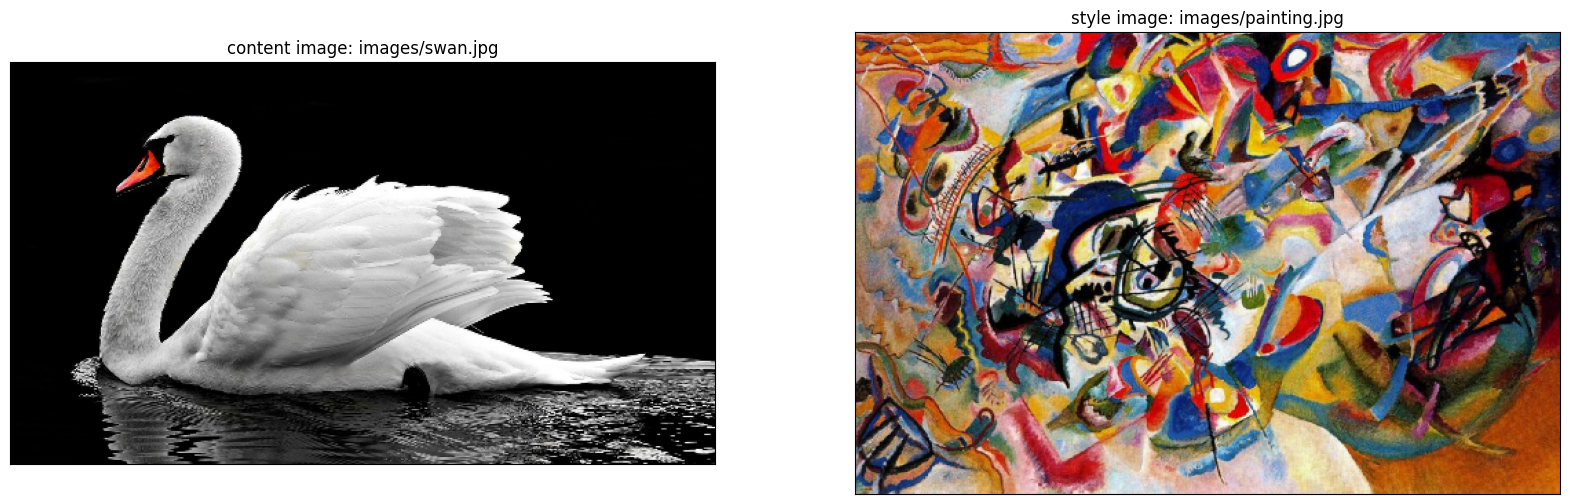

In [109]:
# display the content and style image
contentImage, styleImage = PreProcessing.LoadImages(content_path, style_path)
PreProcessing.imshowall([contentImage, styleImage],
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

Models, Losses, Etc.

In [6]:
# Clear the session to make layer naming consistent when re-running this cell
kb.clear_session()

# Inspecting VGG19
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

574710816/574710816 [==============================] - 17s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [7]:
#Style Layers
styleLayers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

#Content Layer
contentLayers = ['block5_conv2']

output_layers = styleLayers + contentLayers

NUM_CONTENT_LAYERS = len(contentLayers)
NUM_STYLE_LAYERS   = len(styleLayers)

In [8]:
class Models:
    def __init__():
        pass

    @staticmethod
    def VGGModel(LayerNames):
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in LayerNames]
        model=tf.keras.Model(inputs=vgg.input, outputs=outputs)
        return model

In [9]:
kb.clear_session()

# create a vgg-19 model
vgg = Models.VGGModel(output_layers)
vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [10]:
class Losses:
    def __init__():
        pass

    @staticmethod
    def StyleLoss(features, targets):
        """
        Args:
            Features: tensor with shape: (height, width, channels)
            Targets : tensor with shape: (hegiht, width, channels)

        Returns: Style Loss (scalar)
        """
        return tf.reduce_mean(tf.square(features - targets))

    @staticmethod
    def ContentLoss(features, targets):
        """
        Args:
            Features: tensor with shape: (height, width, channels)
            Targets : tensor with shape: (hegiht, width, channels)

        Returns: Content Loss (scalar)
        """
        return 0.5 * tf.reduce_sum(tf.square(features - targets))

    @staticmethod
    def GramMatrix(inputTensor):
        """
        Args:
            inputTensor: tensor of shape (batch, height, width, channels)

        Returns:
            scaledGram: gram matrix devided by the number of locations
        """
        gram = tf.linalg.einsum("bijc,bijd->bcd", inputTensor, inputTensor)

        # get the height and width of the input tensor
        input_shape = tf.shape(inputTensor)
        height = input_shape[1]
        width = input_shape[2]

        num = tf.cast(height * width, tf.float32)

        # scale the gram matrix bu dividing by the number of elements
        scaledGram = gram / num

        return scaledGram

    def TotalLoss(styleTargets, styleOutputs, contentTargets, contentOutputs, styleWeight, contentWeight):
        # sum of the style losses
        styleLoss = tf.add_n([Losses.StyleLoss(styleOutput, styleTarget) for styleOutput, styleTarget in zip(styleOutputs, styleTargets)])

        # sum up the content losses
        contentLoss = tf.add_n([Losses.ContentLoss(contentOutput, contentTarget)
                                for contentOutput, contentTarget in zip(contentOutputs, contentTargets)])

        # scale the style loss by multiplying by the style weight and dividing by the number of style layers
        styleLoss = styleLoss * styleWeight / NUM_STYLE_LAYERS

        # scale the content loss by multiplying by the content weight and dividing by the number of content layers
        contentLoss = contentLoss * contentWeight / NUM_CONTENT_LAYERS

        # sum up the style and content losses
        totalLoss = styleLoss + contentLoss

        return totalLoss


In [11]:
temp = [layer.output for layer in vgg.layers]
temp

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

In [12]:
class Features:
    def __init__():
        pass

    @staticmethod
    def StyleFeatures(image):
        """
        Args:
            image: an input image

        Returns:
            gram_style_features: the style features as gram matrices
        """
        # Preprocess
        preprocessed= PreProcessing.preprocessImage(image)

        # Outputs
        outputs = vgg(preprocessed)

        # Style Features
        styleOutputs = outputs[:NUM_STYLE_LAYERS]

        # for each style layer, calculate the gram matrix for that layer and store these results in a list
        gramStyleFeatures = [Losses.GramMatrix(styleLayer) for styleLayer in styleOutputs]

        return gramStyleFeatures

    @staticmethod
    def ContentFeatures(image):
        """
        Args:
            image: an imput image

        Returns:
            content_output: the content features of the image
        """
        # Preprocess
        preprocessed = PreProcessing.preprocessImage(image)

        # Ouputs
        outputs = vgg(preprocessed)

        # Content Features
        contentOutputs = outputs[NUM_STYLE_LAYERS:]

        # return the content layer outputs of the content image
        return contentOutputs

Calculating Gradients

In [13]:
def calculateGradients(image, styleTargets, contentTargets, styleWeight, contentWeight, varWeight):
    """ Calculate the gradients of the loss with respect to the generated image
    Returns:
        gradients: gradients of the loss with respect to the input image
    """
    with tf.GradientTape() as tape:
        styleFeatures = Features.StyleFeatures(image)
        contentFeatures = Features.ContentFeatures(image)

        loss = Losses.TotalLoss(styleTargets, styleFeatures, contentTargets, contentFeatures, styleWeight, contentWeight)

    gradients = tape.gradient(loss, image)

    return gradients

Update the Image with Style

In [78]:
def StylizeImage(image, styleTargets, contentTargets, styleWeight, varWeight, contentWeight, optimizer):
    gradients = calculateGradients(image, styleTargets, contentTargets,  styleWeight, contentWeight, varWeight)

    optimizer.apply_gradients([(gradients, image)])

    image.assign(PreProcessing.clipImageValues(image))

Style Transfer

In [169]:
def StyleTransfer(styleImage, contentImage, styleWeight=1e-2, contentWeight=1e-4, varWeight=0, optimizer="adam", epochs=1, steps_per_epoch=1):
    """ Performs neural style transfer.
    Returns:
        generated_image: generated image at final epoch
        images: collection of generated images per epoch
    """
    step = 0
    styleTargets = Features.StyleFeatures(styleImage)
    contentTargets = Features.ContentFeatures(contentImage)

    generated= tf.cast(contentImage, dtype=tf.float32)
    generated = tf.Variable(generated)
    # Keep Updating Image with Style
    for n in range(epochs):
        for m in tqdm(range(steps_per_epoch)):
            step += 1
            StylizeImage(generated, styleTargets, contentTargets, styleWeight, varWeight, contentWeight, optimizer)
            if m%5==0:
                clear_output(wait=True)
                displayImg = PreProcessing.TensorToImage(generated)
                display_fn(displayImg)

    # convert to uint8 (expected dtype for images with pixels in the range [0, 255])
    generated = tf.cast(generated, dtype=tf.uint8)

    return generated

In [170]:
from tqdm import tqdm

In [171]:
styleWeight = 2e-2
contentWeight = 1e-2

adam = tf.optimizers.legacy.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.5
    )
)

In [172]:
content_path='/content/Manhattan.jpg'
style_path='/content/Starry-Night.jpg'

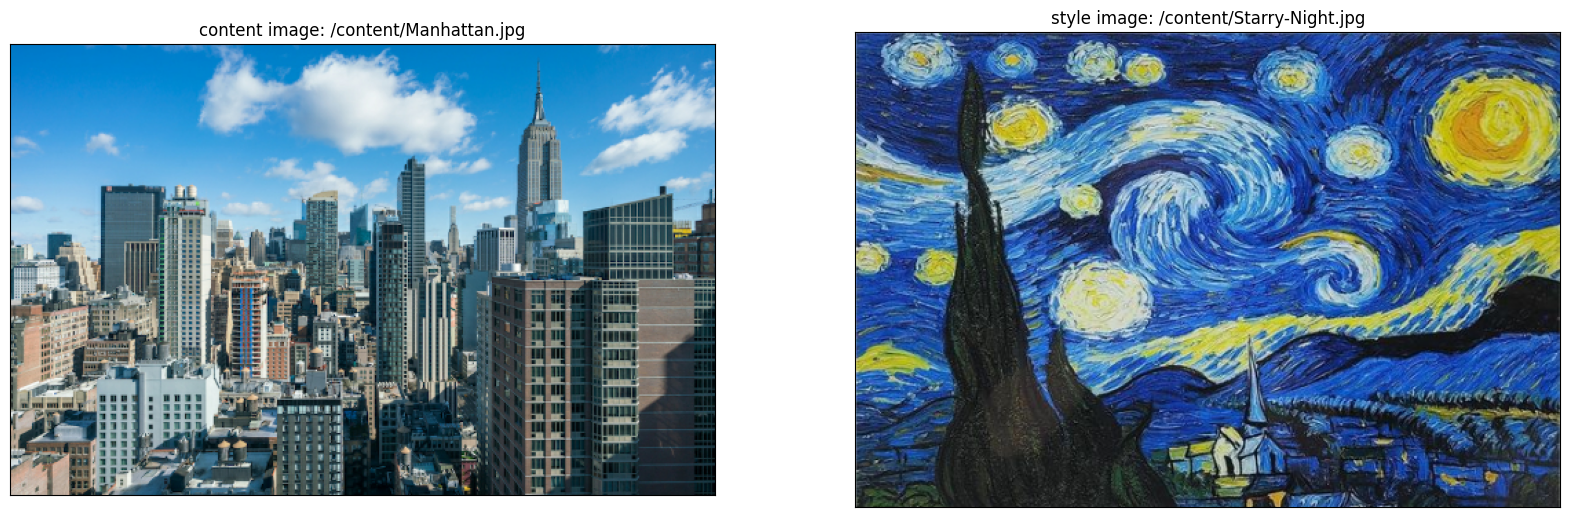

In [173]:
# display the content and style image
contentImage, styleImage = PreProcessing.LoadImages(content_path, style_path)
PreProcessing.imshowall([contentImage, styleImage],
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

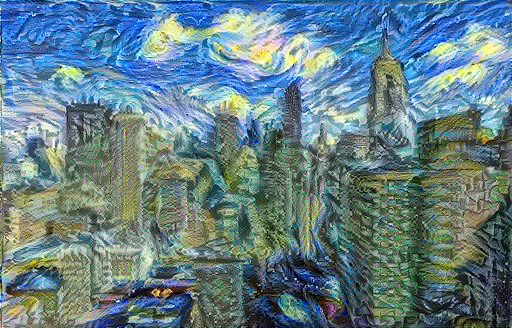

100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


In [174]:
stylizedImage= StyleTransfer(styleImage=styleImage, contentImage=contentImage, styleWeight=styleWeight, contentWeight=contentWeight, varWeight=0, optimizer=adam, epochs=3, steps_per_epoch=100)